$\color{cyan}{\textbf{Assignment 3 - Regression with CNN}}$

Trabalho realizado por:

    Pedro Ferreira Nº2018285801
    Telmo Cunha Nº 2018308321

$\color{cyan}{\textbf{Imports}}$

In [74]:
import os, os.path
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from PIL import Image
import torchvision.transforms as transforms
import torch
import math
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score, recall_score, precision_score
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models
import torchsummary
from torch.utils import data
import pandas as pd
import seaborn as sn
from torchmetrics import MeanSquaredError

mean_squared_error = MeanSquaredError()

$\color{cyan}{\textbf{Get data for dataset}}$

In [75]:
label_type="100"

In [76]:
separation = 10

folderPath = "Image Datasets/crop_part1"
files_paths = os.listdir(folderPath)

img = cv2.imread(os.path.join(folderPath ,files_paths[0]))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape
        
img_data = []
labels_origin = []

for filename in files_paths:
    img = cv2.imread(os.path.join(folderPath ,filename))
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    img_RGB = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_norm = cv2.normalize(img_RGB, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    x = filename.split("_")

    if label_type=="100":
        labels_origin.append(float(x[0]))
    if label_type=="10":
        labels_origin.append(math.floor((int(x[0])+1)/separation))
    if label_type=="gender":
        if len(x)<4:
            continue
        labels_origin.append(int(x[1]))

    img_data.append(img_norm)

img_data = np.array(img_data)
labels_origin = np.array(labels_origin)
print("Total labels: "+str(len(labels_origin)))
print("Total images: "+str(len(img_data)))

Total labels: 9780
Total images: 9780


In [77]:
labels = labels_origin
classes = np.unique(labels)
print("Classes:", classes)
for i in range(len(classes)):
    Classe_N = sum((labels==classes[i]).astype('int'))
    print("Class", classes[i] , "has" ,Classe_N, "samples.")

    if classes[i]>100:
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

    if Classe_N<300 and label_type=="10":
        indexs = np.array(np.where(labels==classes[i])).ravel()
        labels = np.delete(labels, indexs)
        img_data = np.delete(img_data, indexs, 0)

classes = np.unique(labels)
print(classes)
print("Total labels: "+str(len(labels)))
print("Total images: "+str(len(img_data)))

Classes: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  95.  96.  99. 100. 101.
 110.]
Class 1.0 has 1112 samples.
Class 2.0 has 475 samples.
Class 3.0 has 284 samples.
Class 4.0 has 260 samples.
Class 5.0 has 180 samples.
Class 6.0 has 114 samples.
Class 7.0 has 126 samples.
Class 8.0 has 236 samples.
Class 9.0 has 159 samples.
Class 10.0 has 140 samples.
Class 11.0 has 63 samples.
Class 12.0 has 106 samples.
Class 13.0 has 75 samples.
Class 14.0 has 137 samples.
Class 15.0 has 143 samples.
Class 16.0 has 212 samples.
Class 17.0 has 103 samples.
Class 18.0 has 181 sa

In [78]:
target_names = []
c_class = np.unique(labels)
genders = ["Male","Female"]

if label_type=="100":
    for i in range(len(c_class)):
        target_names.append(str(c_class[i]))

if label_type=="10":
    dist = 10
    for i in range(len(np.unique(labels))):
            target_names.append(str(dist*c_class[i])+"-"+str(dist*c_class[i]+dist-1))

if label_type=="gender":
    for i in range(len(np.unique(labels))):
        target_names.append(genders[i])
print(target_names)

['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0', '38.0', '39.0', '40.0', '41.0', '42.0', '43.0', '44.0', '45.0', '46.0', '47.0', '48.0', '49.0', '50.0', '51.0', '52.0', '53.0', '54.0', '55.0', '56.0', '57.0', '58.0', '59.0', '60.0', '61.0', '62.0', '63.0', '64.0', '65.0', '66.0', '67.0', '68.0', '69.0', '70.0', '71.0', '72.0', '73.0', '74.0', '75.0', '76.0', '77.0', '78.0', '79.0', '80.0', '81.0', '82.0', '83.0', '84.0', '85.0', '86.0', '87.0', '88.0', '89.0', '90.0', '91.0', '92.0', '93.0', '95.0', '96.0', '99.0', '100.0']



$\color{cyan}{\textbf{Define pytorch dataset class}}$


In [79]:
class Dataset (data.Dataset):
    def __init__ (self , images , labels):
        self.images = images
        self.labels = labels
        
    def __len__ (self):
        return len(self.images)

    def __getitem__ (self , index ):
        img = np.array(self.images[index])
        img = transforms.ToTensor()(img)
        label = self.labels[index]
        return img,label 
        

$\color{cyan}{\textbf{Data/Image inspection}}$

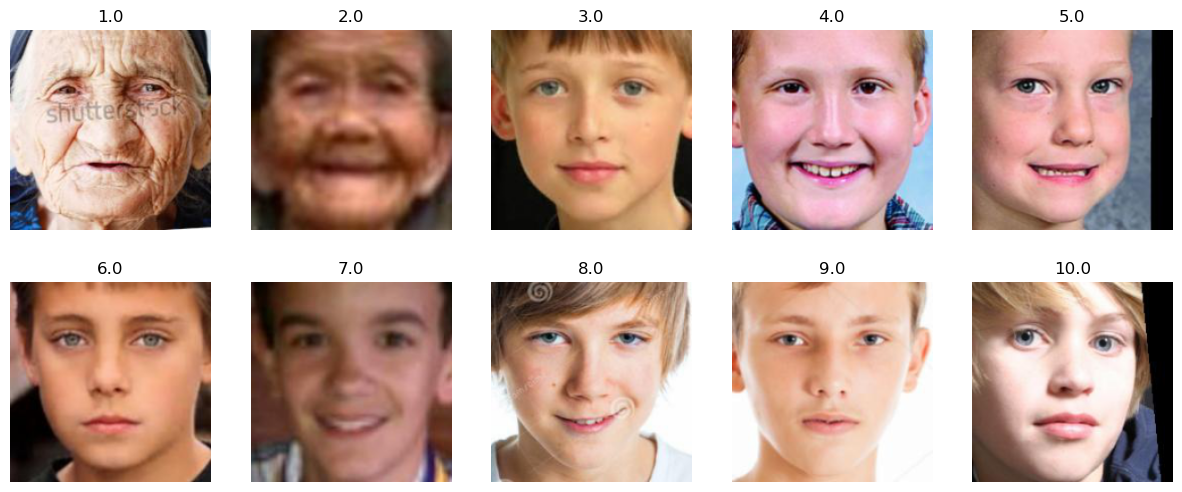

In [80]:
imgs = img_data

fig = plt.figure(figsize=(15, 6))

N_imgs = 0.001*len(labels)
if(N_imgs%2!=0):
    N_imgs += 1
N_imgs = int(N_imgs)

rows = 2
columns = int(N_imgs/rows)

for i in range(N_imgs):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.title(target_names[i])


$\color{cyan}{\textbf{Hyperparameters}}$

In [81]:
batch_size = 128
lr = 0.1
num_epochs = 50

$\color{cyan}{\textbf{Data Splitiing/Loading}}$

In [82]:


dataset = Dataset(images = imgs,labels=labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will run on " + str(device))

test_ratio = 0.2
valid_ratio = 0.2

training_data, testing_data = torch.utils.data.random_split(dataset, [math.floor(len(dataset)*(1-test_ratio)),math.ceil(len(dataset)*test_ratio)])

num_train = len(training_data)
num_test = len(testing_data)
print("Number of images in original training set: " + str(num_train)) 
print("Number of images in original testing set: " + str(num_test))
indices = list(range(num_train))

split = int(np.floor(num_train * valid_ratio ))
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split]
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

training_loader = torch.utils.data.DataLoader(dataset = training_data, batch_size = batch_size, sampler = training_sampler)
valid_loader = torch.utils.data.DataLoader(dataset = training_data, batch_size = batch_size, sampler = valid_sampler)
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, batch_size = batch_size)


The model will run on cuda
Number of images in original training set: 7821
Number of images in original testing set: 1956
Split Number: 1564
Number of training images: 6257
Number of validation images: 1564


$\color{cyan}{\textbf{Batch data inspection}}$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: list index out of range

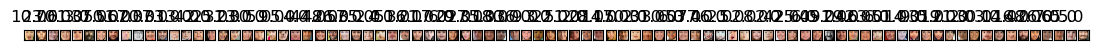

In [83]:
# Visualization of a whole batch
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

label_str = target_names
# Get images
dataiter = iter(training_loader)
images, labels = dataiter.__next__() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(20, 6))

# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    # Add a subplot for the image 
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    image = images[idx].permute(1, 2, 0)
    ax.imshow(image, cmap="gray")
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(label_str[int(labels[idx].item())])

$\color{cyan}{\textbf{Network architecture}}$

In [ ]:
# ResNet18
cnn_model = models.resnet18(weights="IMAGENET1K_V1")

#for param in cnn_model.parameters():
#    param.requires_grad = False
#cnn_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

cnn_model.fc = nn.Sequential(
    nn.Linear(512, 256, bias=True),
    nn.ReLU(),
    nn.Linear(256, 1, bias=True) #Regression only needs 1 output node
)

cnn_model = cnn_model.to(device)

print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 224, 224), batch_size=batch_size)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]          36,864
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
       BasicBlock-11          [128, 64, 56, 56]               0
           Conv2d-12          [128, 64, 56, 56]          36,864
      BatchNorm2d-13          [128, 64, 56, 56]             128
             ReLU-14          [128, 

(tensor(11308097), tensor(11308097))

$\color{cyan}{\textbf{Model Training}}$

In [ ]:
### Training

# Library imports
import torch.optim as optim

# Loss Function
#criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems

criterion = nn.L1Loss()
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.1, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2, verbose=True, factor = 0.5)

# Training
running_loss = 0.0
training_loss = 0.0

y_valid = list()
y_train = list()

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device

    Images = images.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    
    # Create a loss value
    loss = criterion(outputs.ravel(), labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()
    

    # Check some statistics
    training_loss += loss.item()
    running_loss += loss.item()

  print("(Training Set) Epoch: " + str(epoch + 1) + " Loss: " + str(training_loss/(len(training_idx)/batch_size)))
  y_train.append(training_loss/(len(training_idx)/batch_size))
  training_loss = 0
  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images = valid_images.type(torch.FloatTensor)
      valid_labels = valid_labels.type(torch.FloatTensor)
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs.ravel(), valid_labels)

      valid_total_loss += valid_loss.item()
      valid_predicted, _ = torch.max(valid_outputs.data, 1)

      valid_total += 1
      valid_correct += mean_squared_error(valid_outputs.cpu().ravel(), valid_labels.cpu()).item()


  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/(len(valid_idx)/batch_size)) + " Batch Mean MSE: " + str(valid_correct/valid_total))

  # x e y para o plot da loss por epoch

  y_valid.append(valid_total_loss/(len(valid_idx)/batch_size))

  #scheduler.step()
  scheduler.step(valid_total_loss/len(valid_idx))

print("Training is completed!\n")



(Training Set) Epoch: 1 Loss: 10371.17965503636
(Validation Set) Epoch: 1 Loss: 555.3949283687659 Batch Mean MSE: 522.0178480881912
(Training Set) Epoch: 2 Loss: 488.20743267540354
(Validation Set) Epoch: 2 Loss: 439.2707650655371 Batch Mean MSE: 412.8722886305589
(Training Set) Epoch: 3 Loss: 414.99576287058494
(Validation Set) Epoch: 3 Loss: 372.3955103101023 Batch Mean MSE: 350.01597477839545
(Training Set) Epoch: 4 Loss: 310.24094139563687
(Validation Set) Epoch: 4 Loss: 287.51239934662726 Batch Mean MSE: 270.2340111365685
(Training Set) Epoch: 5 Loss: 240.3026497822439
(Validation Set) Epoch: 5 Loss: 233.2967376318734 Batch Mean MSE: 219.27649747408353
(Training Set) Epoch: 6 Loss: 219.26541148913216
(Validation Set) Epoch: 6 Loss: 212.31187310182224 Batch Mean MSE: 199.55274728628305
(Training Set) Epoch: 7 Loss: 196.05098602065686
(Validation Set) Epoch: 7 Loss: 179.03067680027175 Batch Mean MSE: 168.27162229097806
(Training Set) Epoch: 8 Loss: 172.16533779042473
(Validation Set

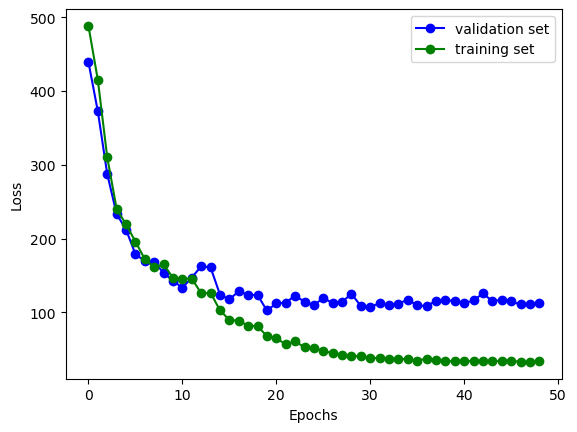

In [ ]:
# plot  
x = list(range(1, num_epochs+1))
plt.plot(y_valid[1:], 'bo-', label ='validation set')
plt.plot(y_train[1:], 'go-', label ='training set')

plt.xlabel("Epochs")
plt.ylabel("Loss")
  
# Function add a legend  
plt.legend()
  
# function to show the plot
plt.show()

$\color{cyan}{\textbf{Test evaluation}}$

In [ ]:
# Evaluate the CNN
num_classes = 2
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

Labels_total = np.zeros(len(testing_data))
Predictions_total = np.zeros(len(testing_data))

cnn_model.eval()

with torch.no_grad():
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data

    images = images.type(torch.FloatTensor)
    labels = labels.type(torch.FloatTensor)

    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    predicted, _ = torch.max(outputs.data, 1)

    # Get model's performance
    Labels_total[batch_size*batch_id : batch_size*(batch_id+1)] = labels.cpu().data.numpy()
    Predictions_total[batch_size*batch_id : batch_size*(batch_id+1)] = predicted.cpu().data.numpy()       


print("MSE:", mean_squared_error(torch.tensor(Predictions_total), torch.tensor(Labels_total)).item())
print("Mean Euclidean distance:", np.sum(np.abs(Labels_total-Predictions_total))/len(Labels_total))



MSE: 117.66145324707031
Mean Euclidean distance: 7.209684499324221


$\color{cyan}{\textbf{Test predictions visualization}}$

In [ ]:
# Function to convert a tensor to an image
def im_convert(tensor):  
  tensor = tensor.permute(1, 2, 0)
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image*255

  image = image.astype(int)
  
  return image

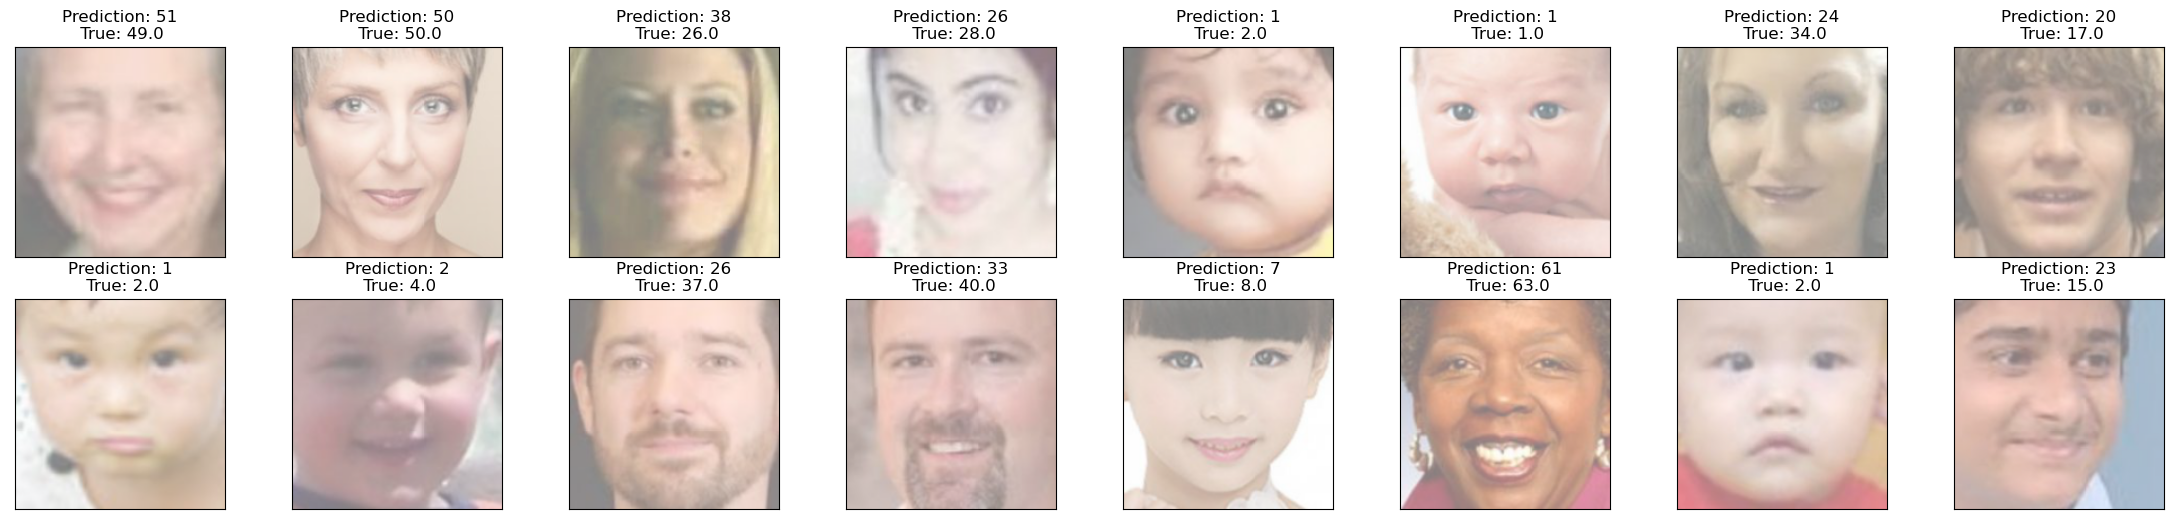

In [ ]:
# Define all the classes, to see the string labels when printing the images
classes = target_names

# Use testing loader to get a batch of images
dataiter = iter(testing_loader)
images, labels = dataiter.__next__()

images = images.type(torch.FloatTensor)
labels = labels.type(torch.FloatTensor)
images = images.to(device)
labels = labels.to(device)

output = cnn_model(images)
preds , _ = torch.max(output, 1)

fig = plt.figure(figsize=(28, 6))

# Plot test images with predictions and labels in between parenthesis
for idx in np.arange(16):
  ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])

  plt.imshow(im_convert(images[idx]))
  ax.set_title("Prediction: "+str(round(preds[idx].item())) + "\n True: " + str(labels[idx].item()))

$\color{cyan}{\textbf{Save/Load model}}$

In [ ]:
# If we need to save the model for later use
torch.save(cnn_model.state_dict(), "model_Resnet18")

In [ ]:
# If w want to load a past model
cnn_model.load_state_dict(torch.load("model_Resnet18", map_location="cuda:0"))

<All keys matched successfully>